In [147]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch

import visualize as vis

In [168]:
def plot_results(dic, m, rng=(), split="valid", lbl="", linestyle="-", fill=True, return_c=True, c=None):
    x = np.arange(len(dic["mean"]["metrics"]["train"][()]["acc"]))
    p = plt.plot(x, dic["mean"]["metrics"][split][rng][m], linestyle=linestyle, label=lbl, color=c)
    if fill:
        plt.fill_between(x, dic["mean"]["metrics"][split][rng][m]-dic["std"]["metrics"][split][rng][m],
                        dic["mean"]["metrics"][split][rng][m]+dic["std"]["metrics"][split][rng][m], alpha=0.3, color=p[0].get_color())
    return p[0].get_color() if return_c else None

In [169]:
def load_stats(path):
    with open(path, "rb") as f:
        dic = pickle.load(f)
    return dic

def make_plot(fnames, metric, split, table=False, ylbl="", title=""):
    means_list, stds_list = [], [] 
    for fnm, mname in fnames.items():
        stats = load_stats("models_all/"+fnm+"/stats_avg.pkl")
        mean_dic, std_dic = stats["mean"]["metrics"][split], stats["std"]["metrics"][split]
        rnges, means, stds = [], [], []
        for rng in list(mean_dic.keys())[1:]:
            rnges.append(np.mean(rng) if rng[-1]<5 else 5)
            means.append(mean_dic[rng][metric])
            stds.append(std_dic[rng][metric])
        means_list.append(np.array(means)), stds_list.append(np.array(stds))

    plt.figure(figsize=(12,3))
    for sub in range(2):
        plt.subplot(1,3,sub+1)
        ttl = title if sub==0 else "Relative differences"
        plt.title(ttl, fontsize=14)

        mean_means = 0 if sub==0 else np.array(means_list).mean(0)
        for i, (fname, mname) in enumerate(fnames.items()):
            mean, std = means_list[i], stds_list[i]
            p = plt.plot(rnges, mean-mean_means, label=mname)
            plt.scatter(rnges, mean-mean_means, c=p[0].get_color(), zorder=20)
            plt.fill_between(rnges, mean-std-mean_means, mean+std-mean_means, alpha=0.3)
        plt.xticks(fontsize=13),plt.yticks(fontsize=13)
        ylbl = ylbl if sub==0 else ylbl + " from mean"
        plt.ylabel(ylbl, fontsize=14)
        plt.xlabel("Transit depth over \nnoise level ( $\delta$ / $\sigma$ )", fontsize=14)
        plt.legend(fontsize=12) if sub==0 else None
    plt.subplot(1,3,3)
    thresholds = np.linspace(0,1,20)
    for i, (fname, mname) in enumerate(fnames.items()):
        stats = load_stats("models_all/"+fname+"/stats_avg.pkl")
        for j, m in enumerate(["thresh_prec", "thresh_rec"]):
            mean = stats["mean"]["metrics"][split][()][m]
            std = stats["std"]["metrics"][split][()][m]
            p = plt.plot(thresholds, mean, linestyle="-" if j==0 else "--", 
                         color=None if j==0 else p[0].get_color(), linewidth=2)
            plt.fill_between(thresholds, mean-std, mean+std, alpha=0.2, color=p[0].get_color())
    plt.plot([], linestyle="-", color="gray", label="precision")    
    plt.plot([], linestyle="--", color="gray", label="recall")
    plt.legend(fontsize=12, bbox_to_anchor=(1,1))
    plt.xticks(fontsize=13), plt.yticks(fontsize=13)
    plt.xlabel("Classification threshold", fontsize=14), plt.ylabel("Metric value", fontsize=14)
    plt.tight_layout()
    plt.show()

In [170]:
os.listdir("models_all")

['.DS_Store',
 'lcsim1500_bigru1_m0',
 'lcsim1500_bigru1_m1',
 'lcsim1500_bigru1_m1_w12.6',
 'lcsim1500_bigru1_m1_w1snr',
 'lcsim1500_bigru1_m1_w1sqrt',
 'lcsim1500_bigru1_m1_w3',
 'lcsim1500_bigru1_m1_w3snr',
 'lcsim1500_bigru1_m1_w3sqrt',
 'lcsim1500_bigru1_m2',
 'lcsim1500gaps_bigru1_m1_n1',
 'lcsim1500gaps_bigru1_m1_n2',
 'lcsim1500gaps_bigru1gen_m1_n0',
 'lilith1500basic_bigru1_m0_n1',
 'lilith1500basic_bigru1_m0_n2',
 'lilith1500basic_bigru1_m1_n1',
 'lilith1500basic_bigru1_m1_n2',
 'lilith1500basic_bigru1_m1_w3',
 'lilith1500basic_bigru1_m1_w3snr',
 'lilith1500basic_bigru1_m1_w3sqrt',
 'lilith1500basic_bigru1_m2_n2',
 'lilith1500basic_bigru1centr_m1_n2_w3sqrt',
 'lilith1500hrd_bigru1_m1_n2_w3sqrt',
 'lilith1500lrd_bigru1_m1_n2_w3sqrt',
 'lilith1500outlier_bigru1_m1_n2_w3sqrt']

# LCSim

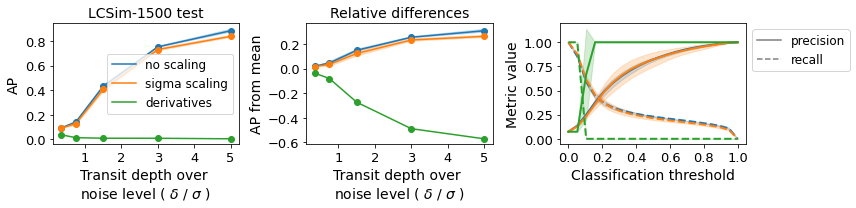

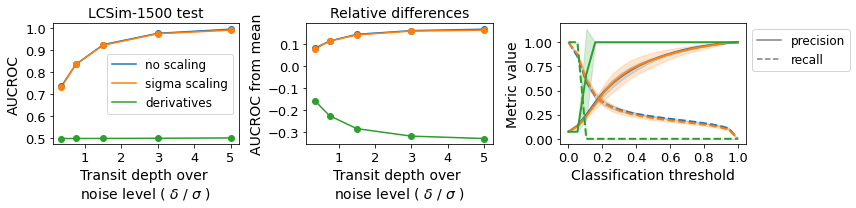

In [171]:
fnames = {"lcsim1500_bigru1_m0":"no scaling",
          "lcsim1500_bigru1_m1":"sigma scaling",
          "lcsim1500_bigru1_m2":"derivatives"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="AP", title="LCSim-1500 test")
metric, split = "aucroc", "test"
make_plot(fnames, metric, split, ylbl="AUCROC", title="LCSim-1500 test")

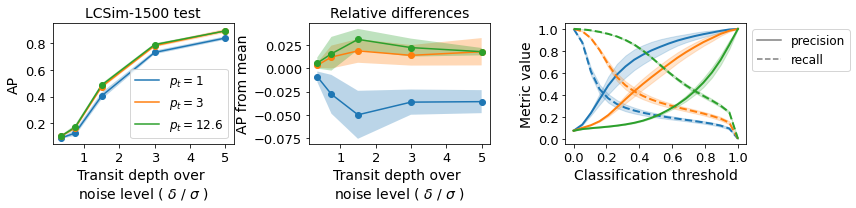

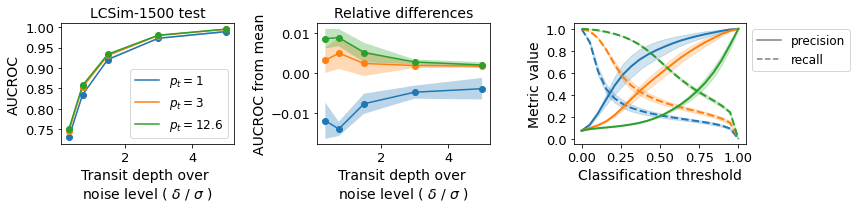

In [172]:
fnames = {"lcsim1500_bigru1_m1"       :"$p_t = 1$",
          'lcsim1500_bigru1_m1_w3'    :"$p_t = 3$",
          'lcsim1500_bigru1_m1_w12.6' :"$p_t = 12.6$"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="AP", title="LCSim-1500 test")
metric, split = "aucroc", "test"
make_plot(fnames, metric, split, ylbl="AUCROC", title="LCSim-1500 test")

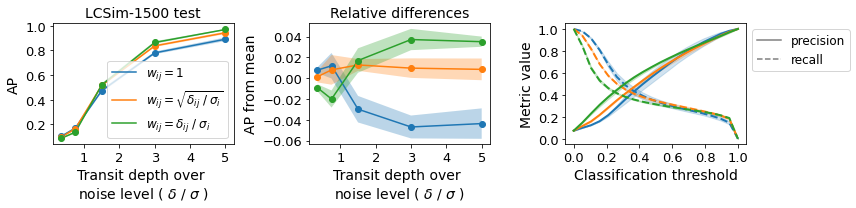

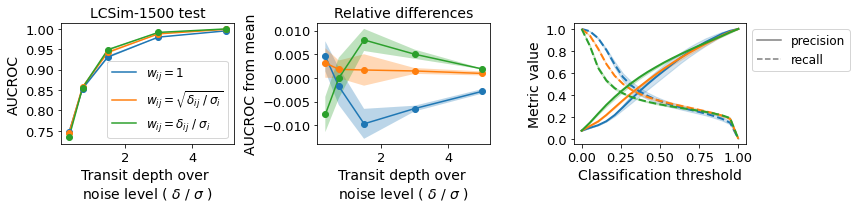

In [173]:
fnames = {'lcsim1500_bigru1_m1_w3'    :"$w_{ij} = 1$",
          'lcsim1500_bigru1_m1_w3sqrt' :"$w_{ij} = \sqrt{\delta_{ij} \;/ \; \sigma_i}$",
          'lcsim1500_bigru1_m1_w3snr':"$w_{ij} = \delta_{ij} \; / \; \sigma_i$"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="AP", title="LCSim-1500 test")
metric, split = "aucroc", "test"
make_plot(fnames, metric, split, ylbl="AUCROC", title="LCSim-1500 test")

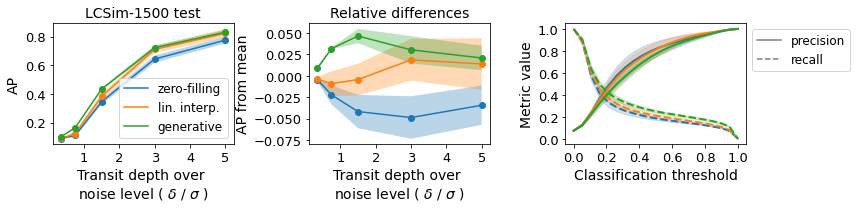

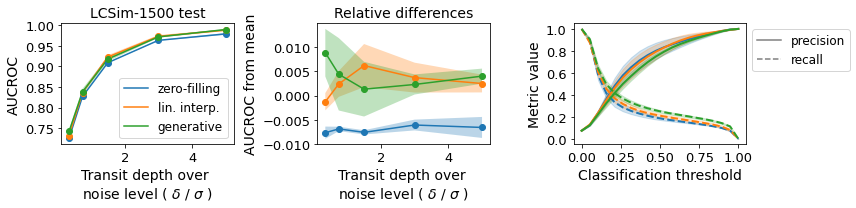

In [174]:
fnames = {"lcsim1500gaps_bigru1_m1_n1":"zero-filling",
          'lcsim1500gaps_bigru1_m1_n2':"lin. interp.",
          'lcsim1500gaps_bigru1gen_m1_n0':"generative"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="AP", title="LCSim-1500 test")
metric, split = "aucroc", "test"
make_plot(fnames, metric, split, ylbl="AUCROC", title="LCSim-1500 test")

# Lilith

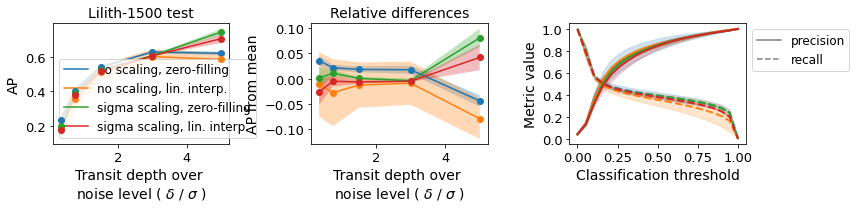

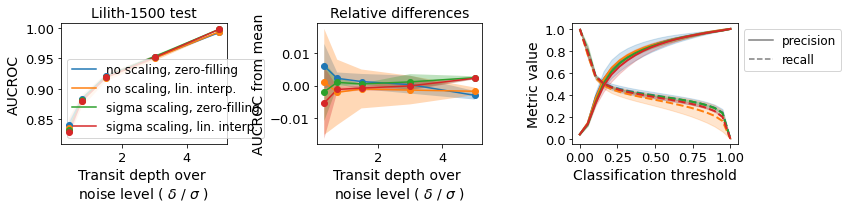

In [175]:
fnames = {'lilith1500basic_bigru1_m0_n1': "no scaling, zero-filling",
          'lilith1500basic_bigru1_m0_n2': "no scaling, lin. interp.",
          'lilith1500basic_bigru1_m1_n1': "sigma scaling, zero-filling",
          'lilith1500basic_bigru1_m1_n2': "sigma scaling, lin. interp."}
          #'lilith1500basic_bigru1_m2_n2': "sigma scaling, lin. interp., derivatives"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="AP", title="Lilith-1500 test")
metric, split = "aucroc", "test"
make_plot(fnames, metric, split, ylbl="AUCROC", title="Lilith-1500 test")

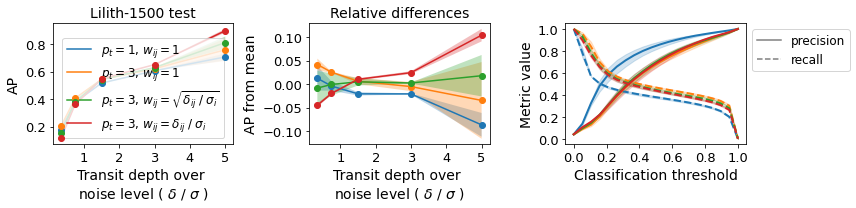

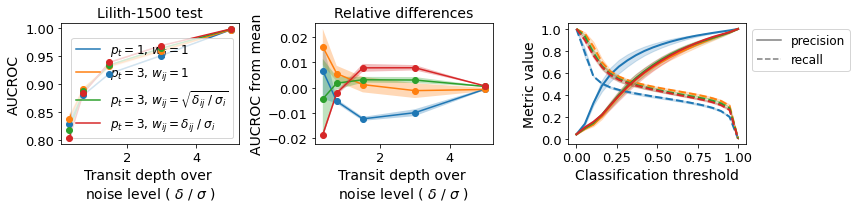

In [177]:
fnames = {'lilith1500basic_bigru1_m1_n2'    :"$p_t = 1$, $w_{ij} = 1$",
          'lilith1500basic_bigru1_m1_w3'    :"$p_t = 3$, $w_{ij} = 1$",
          'lilith1500basic_bigru1_m1_w3sqrt':"$p_t = 3$, $w_{ij} = \sqrt{\delta_{ij} \;/ \; \sigma_i}$",
          'lilith1500basic_bigru1_m1_w3snr':"$p_t = 3$, $w_{ij} = \delta_{ij} \; / \; \sigma_i$"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="AP", title="Lilith-1500 test")
metric, split = "aucroc", "test"
make_plot(fnames, metric, split, ylbl="AUCROC", title="Lilith-1500 test")

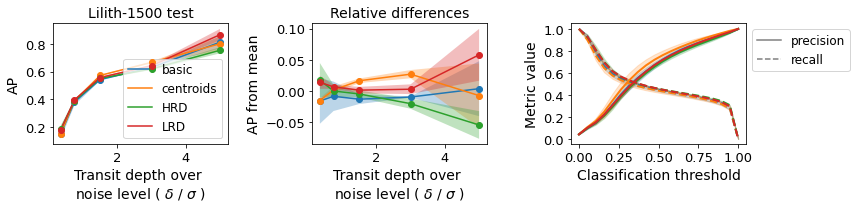

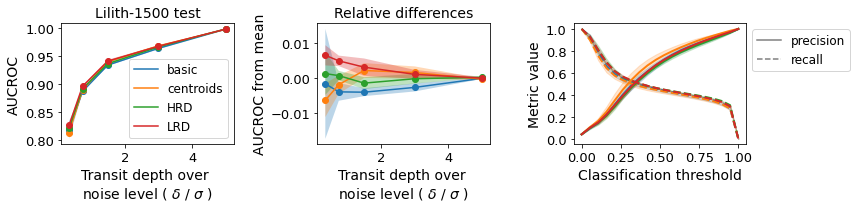

In [179]:
fnames = {'lilith1500basic_bigru1_m1_w3sqrt':"basic",
          'lilith1500basic_bigru1centr_m1_n2_w3sqrt':"centroids",
          'lilith1500hrd_bigru1_m1_n2_w3sqrt':"HRD",
          'lilith1500lrd_bigru1_m1_n2_w3sqrt':"LRD"}
          #'lilith1500outlier_bigru1_m1_n2_w3sqrt':"outliers"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="AP", title="Lilith-1500 test")
metric, split = "aucroc", "test"
make_plot(fnames, metric, split, ylbl="AUCROC", title="Lilith-1500 test")

## ... Old ...

## Scaling
Scaling by (white-)noise estimate, standardizing, feeding derivatives

In [ ]:
results = {"mscale0_mode1":'bigru1_w4snr_sim_mscale0_stddize1_mode1_nanmode0.pkl',
           "mscale1_mode1":'bigru1_w4snr_sim_mscale1_stddize1_mode1_nanmode0.pkl',
           "mscale1_mode0":'bigru1_w4snr_sim_mscale1_stddize1_mode0_nanmode0.pkl',
           "mscale0_mode2":'bigru1_w4snr_sim_mscale0_stddize1_mode2_nanmode0.pkl',
           "mscale0_mode3":'bigru1_w4snr_sim_mscale0_stddize1_mode3_nanmode0.pkl'}
for r in results:
    with open("results/preprocessing/"+results[r], "rb") as f:
        results[r] = pickle.load(f)

In [ ]:
dontshow=[]
plt.figure(figsize=(10,4))
for mname in [m for m in results if m not in dontshow]:
    plot_results(results[mname], "acc_seg", split="valid", lbl=mname, fill=1)
plt.legend(fontsize=12, bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show() 

## Data gaps
Simulated gaps, zero-filling, linear interpolation, predicting missing values.

In [ ]:
results = {"nanmode1":'bigru1_w4snr_simgap_mscale1_stddize1_mode1_nanmode1.pkl',
            "nanmode2":'bigru1_w4snr_simgap_mscale1_stddize1_mode1_nanmode2.pkl',
           "nanmode0":'bigru1gen_w4snr_simgap_mscale1_stddize1_mode1_nanmode0.pkl',
           "mscale1_mode1":'bigru1_w4snr_sim_mscale1_stddize1_mode1_nanmode0.pkl'}
for r in results:
    with open("results/preprocessing/"+results[r], "rb") as f:
        results[r] = pickle.load(f)

In [ ]:
dontshow=[]
plt.figure(figsize=(10,4))
for mname in [m for m in results if m not in dontshow]:
    plot_results(results[mname], "tpr", split="valid", lbl=mname, fill=0)
plt.legend(fontsize=12, bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show() 

## Lilith specific
Outlier removal, low-risk detrending (compare vs non-scaled flux segments)

In [92]:
with open("results/low_risk_flatten_lc.pkl", "rb") as f:
    lc = pickle.load(f)

toffs = lc["time"][0]
lc["time"]-=toffs

In [155]:
sigma = np.nanstd(flatten(lc["time"], lc["flux"], method="median", window_length=utils.hour2day(0.5)))
fluxes = [lc["flux"], lc["flat"], np.diff(lc["flux"], prepend=lc["flux"][0])]
fluxes2 = [lc["flux"], np.diff(lc["flux"]/sigma, prepend=lc["flux"][0]),lc["flat"]]
spans = [i-toffs for i in [1321, 1327]]
span_t = utils.min2day(1500 * 2)
cs = [plt.plot([])[0].get_color() for i in range(2)]
plt.close()

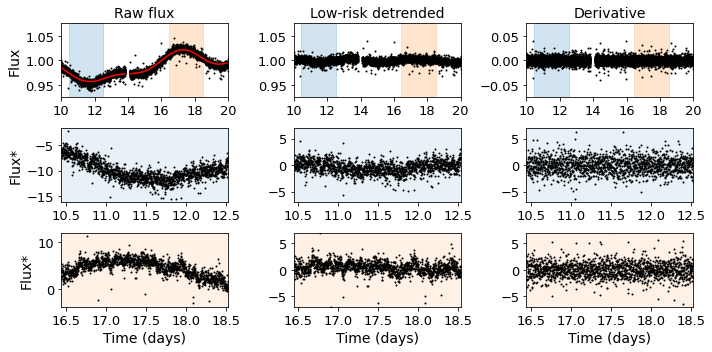

In [150]:
titles=["Raw flux", "Low-risk detrended", "Derivative"]
plt.figure(figsize=(10,5))
for i, fl in enumerate(fluxes):
    
    plt.subplot(3,3,i+1)
    plt.title(titles[i], fontsize=14)
    for j, sp_t in enumerate(spans):
        plt.axvspan(sp_t, sp_t+span_t, alpha=0.2, zorder=-1, color=cs[j])
    vis.plot(lc["time"], fl)
    vis.plot(lc["time"], lc["trend"], scatter=0, c="red", s=1.5) if i==0 else None
    
    plt.xlim(10,20)
    plt.ylim(0.925, 1.075) if i != 2 else plt.ylim(0.925-1, 1.075-1)
    plt.ylabel("Flux", fontsize=14) if i==0 else None
    plt.xticks(fontsize=13)
    
    for j, sp_t in enumerate(spans):
        plt.subplot(3,3,i+1+(j+1)*3)
        plt.axvspan(sp_t, sp_t+span_t, alpha=0.1, zorder=-1, color=cs[j])
        plt.xlim(sp_t, sp_t+span_t)
        msk = (lc["time"]>=sp_t) & (lc["time"]<=sp_t+span_t)
        if i != 2:
            vis.plot(lc["time"][msk], (fl[msk]-1)/sigma)
            
        else:
            vis.plot(lc["time"][msk], fl[msk]/sigma)
        plt.ylim(-7,7) if i!=0 else None
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.xlabel("Time (days)", fontsize=14) if j==1 else None
        plt.ylabel("Flux*", fontsize=14) if i==0 else None
#     plt.show()
plt.tight_layout()

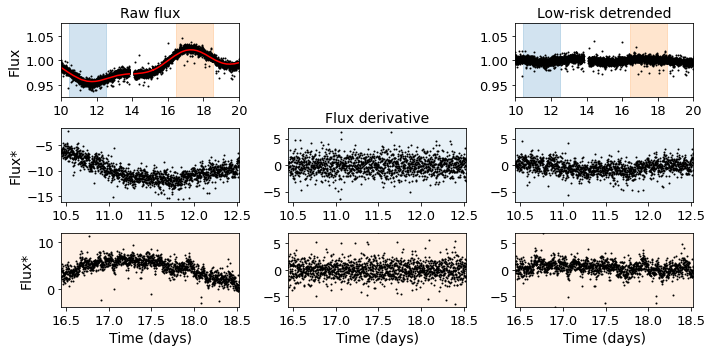

In [159]:
titles=["Raw flux", "Flux derivative", "Low-risk detrended"]
plt.figure(figsize=(10,5))
for i, fl in enumerate(fluxes2):
    if i!=1:
        plt.subplot(3,3,i+1)
        plt.title(titles[i], fontsize=14)
        for j, sp_t in enumerate(spans):
            plt.axvspan(sp_t, sp_t+span_t, alpha=0.2, zorder=-1, color=cs[j])
        vis.plot(lc["time"], fl)
        vis.plot(lc["time"], lc["trend"], scatter=0, c="red", s=1.5) if i==0 else None

        plt.xlim(10,20)
        plt.ylim(0.925, 1.075) if i != 1 else plt.ylim(0.925-1, 1.075-1)
        plt.ylabel("Flux", fontsize=14) if i==0 else None
        plt.xticks(fontsize=13)
    
    for j, sp_t in enumerate(spans):
        plt.subplot(3,3,i+1+(j+1)*3)
        plt.title(titles[i], fontsize=14) if i==1 and j==0 else None
        plt.axvspan(sp_t, sp_t+span_t, alpha=0.1, zorder=-1, color=cs[j])
        plt.xlim(sp_t, sp_t+span_t)
        msk = (lc["time"]>=sp_t) & (lc["time"]<=sp_t+span_t)
        if i != 1:
            vis.plot(lc["time"][msk], (fl[msk]-1)/sigma)
        else:
            vis.plot(lc["time"][msk], fl[msk])
        plt.ylim(-7,7) if i!=0 else None
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.xlabel("Time (days)", fontsize=14) if j==1 else None
        plt.ylabel("Flux*", fontsize=14) if i==0 else None
#     plt.show()
plt.tight_layout()

In [56]:
np.nanstd(fl_)

0.003959913490067476